In [1]:
import numpy as np
from scipy.optimize import dual_annealing
from scipy.integrate import trapezoid
from sklearn.metrics import max_error
import matplotlib.pyplot as plt

# Laterally Loaded Pile Calculator

---

Designer: BLK | Checker: CF | Date: 2025-06-06

---

# 1.0 Givens

## 1.1 Pile Givens



In [2]:
E = 35000 # MPa
I = ((750**4)/12)/10 # mm^4
diameter = 0.75 # m

## 1.2 Loading Givens

In [3]:
P = 270 # kN
d1 = 1.8 # Depth of point load above ground (m)

## 1.3 p-y Curve Givens

In [4]:
c_u = 50 # kPa
e_50 = 0.007 # mm/mm
y_50 = 2.5*e_50*diameter # mm
J = 0.5 # Standard assumption
gamma = 21 # kN/m^3
gamma_p = gamma-9.81

# From Matlock (1970) - For soft clay with free water

def calc_pu(z):
    p_u = min(3+(gamma_p/c_u+J/diameter)*z,9)*c_u*diameter # kN/m
    return p_u

def calc_p(p_u,y):
    p = p_u/2*(abs(y/1000)/y_50)**(1/3)
    if y>0:
        p=-p
    return p*0.9

# 2.0 Pile Givens

In [5]:
# Anticipated ranges
d2_range = (0.1,25) # Unknown pile length to point of rotation
d3_range = (0.1,25) # Unknown pile length beyond point of rotation
theta_range = (0.001,np.deg2rad(3.5)) # Angle of rotation (I do not want to allow rotation exceeding 2.5 deg - try to minimize this angle while keeping the model stable_
bounds = [d2_range, d3_range, theta_range]
discretization = 100 # How many finite elements; if larger, will take longer to run

In [6]:
def f(vars):
    d2,d3,theta = vars
    # Define x along pile length (m)
    # Define x along pile length (m)
    l=d1+d2+d3 # Pile length (m)
    num_elements = discretization
    dx=l/num_elements*1000 # mm
    x = np.linspace(0,l,num_elements+1) # m
    x_ref_d1 = (x-d1)*(x>=d1) # x starting at d1 (m)
    x_ref_d2 = -1*(x - d1-d2) # x with d2 equalling zero (m)
    
    for i in range(len(x)):
        pu_i=calc_pu(x_ref_d1[i])
    
    # Cantilever moment and ensueing deflection
    M_cant = P*x # kNm
    y_cant = P*1000/(6*E*I)*(2*(l*1000)**3-3*(l*1000)**2*(x*1000)+(x*1000)**3) #mm
    
    # Rotational deflection
    y_rot = x_ref_d2*theta*1000 # mm
    
    # Forces in soil due to rotational and cantilever deflections
    
    y_prev = y_cant+y_rot # mm
    y_soil_prev = y_prev*(x>d1) # mm
    
    tolerance=0.5 #mm
    diff=1000
    iteration =0
    while diff>tolerance:
        
        M_soil = np.zeros(len(x))
        P_soil = np.zeros(len(x))
        M = np.zeros(len(x))
        y = np.zeros(len(x))
        slope = np.zeros(len(x))
        
        for i in range(len(x)):
            P_soil[i]=calc_p(pu_i,y_soil_prev[i])
            
        for i in range(len(x)):
            lever_arm = (x[i]-x)*(x<=x[i])
            P_times_lever_arm = P_soil*lever_arm
            M_soil[i]=trapezoid(P_times_lever_arm,x)
        
        M = M_cant+M_soil
    
        M_over_EI = np.flip(M) / (E*I)*1000**2 # 1/mm
    
        slope[1:] = np.cumsum(0.5 * (M_over_EI[1:] + M_over_EI[:-1]) * dx)
        
        y[1:] = np.cumsum(0.5 * (slope[1:] + slope[:-1]) * dx)
        y = np.flip(y) + y_rot
        diff=max_error(y,y_prev)
        y_prev=y
        y_soil_prev = y_prev*(x>d1)
        iteration += 1
        if iteration>5:
            break
    
    M_bot = M[-1]
    # Moment starting from bottom of pile to point load location
    P_soil_flipped = np.flip(P_soil)
    x_flipped = np.flip(x)
    P_times_lever_arm_flipped = P_soil_flipped*x_flipped
    M_top=trapezoid(P_times_lever_arm_flipped,x)
    
    # Force equilibrium
    Sum_F = trapezoid(P_soil,x)+P
    
    objective = M_bot**2+M_top**2+Sum_F**2
    return objective,x,M,y,d2,d3,np.rad2deg(theta),l,P_soil

def calc_objective_result(vars):
    return f(vars)[0]

In [7]:
objective_result = dual_annealing(calc_objective_result, bounds, seed=42)
val, x, M, deflec, d2, d3, theta,l,P_soil = f(objective_result.x)

print(f"Objective result (sum of squares): {val:.4f}")

Objective result (sum of squares): 0.0000


In [8]:
print("\n---Results---")
print(f"Optimal d2: {d2:.3f} m, d3: {d3:.3f} m, theta: {theta:.4f} deg")
print(f"Therefore, unfactored embedment length required: {d2+d3:.3f} m")


---Results---
Optimal d2: 2.720 m, d3: 1.767 m, theta: 3.3990 deg
Therefore, unfactored embedment length required: 4.487 m


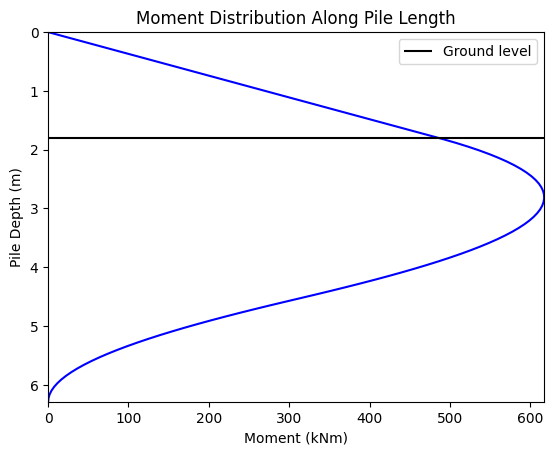

In [9]:
plt.figure()
plt.plot(M,x,'b')
plt.hlines(d1,0,max(M),colors="k",linestyles='solid',label="Ground level")
plt.xlabel("Moment (kNm)")
plt.ylabel("Pile Depth (m)")
plt.title("Moment Distribution Along Pile Length")
plt.xlim(0,max(M))
plt.ylim(plt.ylim(0,l)[::-1])
plt.legend()
plt.show()

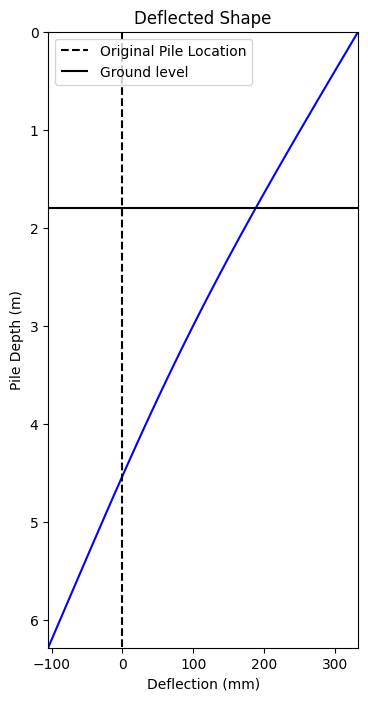

In [10]:
plt.figure(figsize=[4,8])
plt.plot(deflec,x,"b")
plt.vlines(0,0,l,colors='k',linestyles='dashed',label='Original Pile Location')
plt.hlines(d1,min(deflec),max(deflec),colors="k",linestyles='solid',label="Ground level")
plt.xlabel("Deflection (mm)")
plt.ylabel("Pile Depth (m)")
plt.title("Deflected Shape")
plt.xlim(min(deflec),max(deflec))
plt.ylim(plt.ylim(0,l)[::-1])
plt.legend()
plt.show()

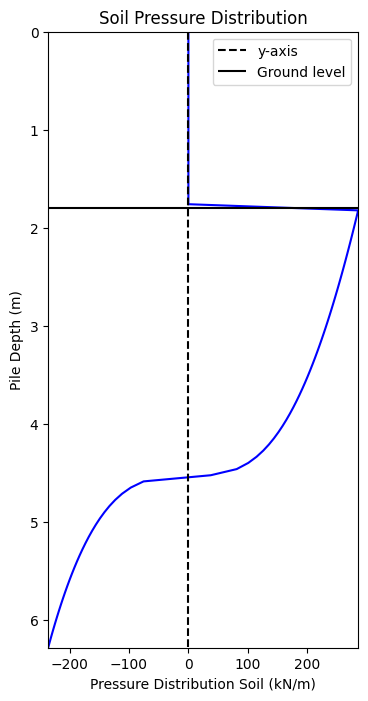

In [12]:
plt.figure(figsize=[4,8])
plt.plot(-P_soil,x,"b")
plt.vlines(0,0,l,colors='k',linestyles='dashed',label='y-axis')
plt.hlines(d1,min(-P_soil),max(-P_soil),colors="k",linestyles='solid',label="Ground level")
plt.xlabel("Pressure Distribution Soil (kN/m)")
plt.ylabel("Pile Depth (m)")
plt.title("Soil Pressure Distribution")
plt.xlim(min(-P_soil),max(-P_soil))
plt.ylim(plt.ylim(0,l)[::-1])
plt.legend()
plt.show()